[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/arplaboratory/data-driven-system-identification/blob/main/sysid.ipynb)

In [1]:
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import os

/home/miller/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
model_name = "crazyflie" # "crazyflie" or "large"
output_topic = "actuator_motors_mux"
inertia_ratio = 1.832
exponents_thrust_curve = [[0, 1, 2], [2]] if model_name == "crazyflie" else [[0, 1, 2]]
dpi=800
debug=False
create_motor_delay_animation=False

In [3]:
rotor_x_displacement = 0.045961940777125586/2
rotor_y_displacement = 0.045961940777125586/2
model = {
    "gravity": 9.81,
    "mass": 0.0368,
    "rotor_positions": np.array([
        [ rotor_x_displacement, -rotor_y_displacement, 0],
        [-rotor_x_displacement, -rotor_y_displacement, 0],
        [-rotor_x_displacement,  rotor_y_displacement, 0],
        [ rotor_x_displacement,  rotor_y_displacement, 0]
    ]),
    "rotor_thrust_directions": np.array([
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1]
    ]),
    "rotor_torque_directions": np.array([
        [0, 0, -1],
        [0, 0,  1],
        [0, 0, -1],
        [0, 0,  1]
    ])
}
g = np.array([0, 0, -model["gravity"]])

# Step 0: Load the data

In [10]:
import pandas as pd

data_file = 'flight_data/20251007_202504.csv'

df = pd.read_csv(data_file)
flights = []
flight = {}
flight["name"] = 'stampfly'
flight["convention"] = "flu"
flight["data"] = {}
timestamps = df['elapsedTime']
flight["data"]["vehicle_acceleration_xyz[0]"] = {"timestamps": timestamps, "values":     np.array(df['accelX'] * 9.81)} # accelerometer logs are in gs
flight["data"]["vehicle_acceleration_xyz[1]"] = {"timestamps": timestamps, "values":     np.array(df['accelY'] * 9.81)}
flight["data"]["vehicle_acceleration_xyz[2]"] = {"timestamps": timestamps, "values":     np.array(df['accelZ'] * 9.81)}
flight["data"]["vehicle_angular_velocity_xyz[0]"] = {"timestamps": timestamps, "values": np.array(df['roll_rate'])} # cf gyro logs are in degrees/s
flight["data"]["vehicle_angular_velocity_xyz[1]"] = {"timestamps": timestamps, "values": np.array(df['pitch_rate'])}
flight["data"]["vehicle_angular_velocity_xyz[2]"] = {"timestamps": timestamps, "values": np.array(df['yaw_rate'])}
for i, key in enumerate(['frontRight_motor_duty', 'frontLeft_motor_duty', 'rearRight_motor_duty', 'rearLeft_motor_duty']):
    value = df[key]
    flight["data"][f"{output_topic}_control[{i}]"] = {"timestamps": timestamps, "values": np.array(value)}
flights.append(flight)

### API
List of separate flights (probably from the same .ulog, arm->disarm). 
```
flights = {
    "name": "flight1.ulg",
    "data": {
        "vehicle_acceleration_xyz[0]": {
            "timestamps": [0, 0.001, 0.002, ...],
            "values": [1, 0.99, 0.98, ...]
        },
        ...
        "vehicle_angular_velocity_xyz[0]": {...},
        ...
        "vehicle_angular_velocity_xyz_derivative[0]": {...},
        ...
        "actuator_motors_control[0]": {...},
        ...
    }
}
```
Note: The timestamps do not need to be synchronized, and the frequencies of logging can vary between the timeseries. They will be synchronized and interpolated based on the highest frequency one
Note2: To gather these datapoints in PX4: Enable the high-rate and system identification topics under `SDLOG_PROFILE`. You might also want to start the logger at a higher rate from the Mavlink console:
```
logger stop
logger start -r 1000 -b 100
```
You should make sure that the buffer size is large enough so that there are no gaps in your logs

# Step 1: Plot the flights

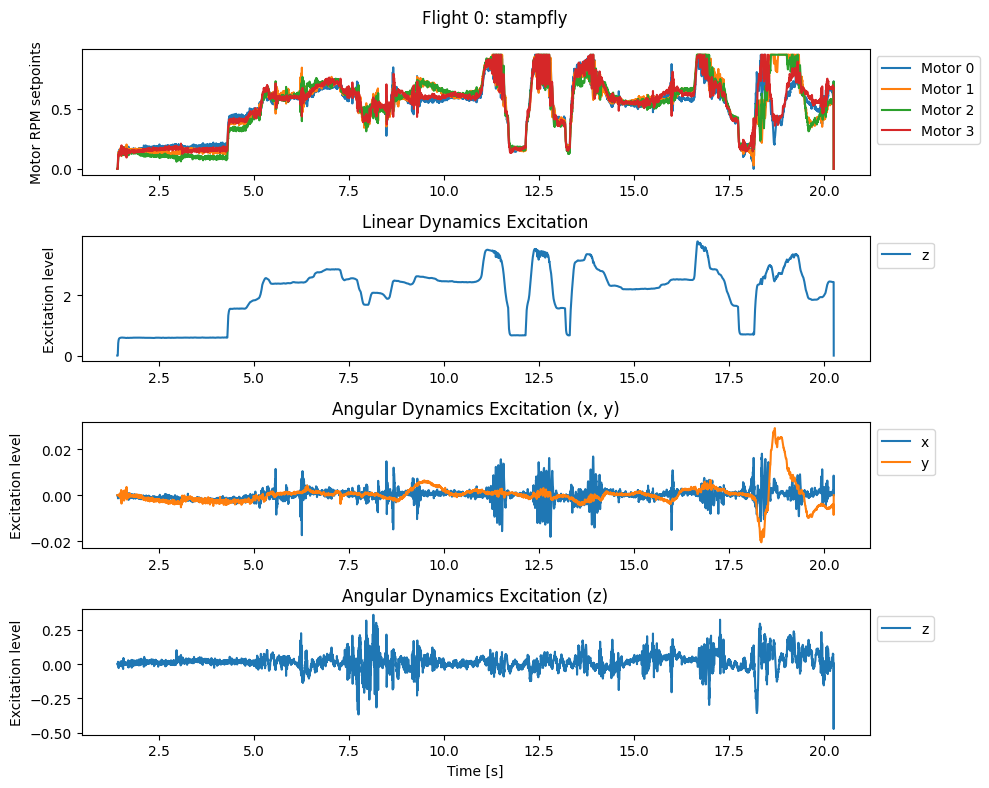

In [11]:
for flight_i, flight in enumerate(flights):
    fig, axs = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

    ax = 0
    for motor_i, motor in enumerate([f"{output_topic}_control[{i}]" for i in range(4)]):
        axs[ax].plot(flight["data"][motor]["timestamps"], flight["data"][motor]["values"], label=f"Motor {motor_i}")
        axs[ax].legend(loc='upper left', bbox_to_anchor=(1,1))
        axs[ax].set_ylabel('Motor RPM setpoints')
    ax += 1
    thrust_values = []
    thrust_torque_values = []
    geometric_torque_values = []
    timestamps = None
    for motor_i, motor in enumerate([f"{output_topic}_control[{i}]" for i in range(4)]):
        timestamps = flight["data"][motor]["timestamps"]
        thrust_values.append(flight["data"][motor]["values"][:, np.newaxis] * model["rotor_thrust_directions"][motor_i][np.newaxis, :])
        thrust_torque_values.append(flight["data"][motor]["values"][:, np.newaxis] * model["rotor_torque_directions"][motor_i][np.newaxis, :])
        geometric_torque_values.append(flight["data"][motor]["values"][:, np.newaxis] * np.cross(model["rotor_positions"][motor_i], model["rotor_thrust_directions"][motor_i])[np.newaxis, :])
    thrust_values = sum(thrust_values)
    thrust_torque_values = sum(thrust_torque_values)
    geometric_torque_values = sum(geometric_torque_values)

    axs[ax].set_title("Linear Dynamics Excitation")
    axs[ax].plot(timestamps, thrust_values[:, 2], label="z")
    axs[ax].legend(loc='upper left', bbox_to_anchor=(1,1))
    axs[ax].set_ylabel('Excitation level')
    ax += 1
    
    axs[ax].set_title("Angular Dynamics Excitation (x, y)")
    axs[ax].plot(timestamps, geometric_torque_values[:, 0], label="x")
    axs[ax].legend(loc='upper left', bbox_to_anchor=(1,1))
    axs[ax].set_ylabel('Geometry Torque (x)')
    axs[ax].plot(timestamps, geometric_torque_values[:, 1], label="y")
    axs[ax].legend(loc='upper left', bbox_to_anchor=(1,1))
    axs[ax].set_ylabel('Excitation level')
    ax += 1
    
    axs[ax].set_title("Angular Dynamics Excitation (z)")
    axs[ax].plot(timestamps, thrust_torque_values[:, 2], label="z")
    axs[ax].legend(loc='upper left', bbox_to_anchor=(1,1))
    axs[ax].set_ylabel('Excitation level')
    ax += 1

    axs[-1].set_xlabel('Time [s]')
    for ax in axs[:-1]:
        ax.xaxis.set_tick_params(labelbottom=True)
    plt.tight_layout()
    os.makedirs("figures", exist_ok=True)
    plt.savefig(f"figures/{model_name}_flight{flight_i}.pdf")
    plt.savefig(f"figures/{model_name}_flight{flight_i}.jpg", dpi=dpi)
    fig.suptitle(f"Flight {flight_i}: {flight['name']}")
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.show()
    

# Step 2: Select Flights and Time Slices

In [12]:
if model_name == "crazyflie":
    timeframes_thrust = [
        {
            "flight": 0,
            "start": 5,
            "end": 19
        }
    ]
    timeframes_inertia_roll_pitch = [
        {
            "flight": 1,
            "start": 55,
            "end": 90
        }
    ]
    timeframes_inertia_yaw = [
        {
            "flight": 2,
            "start": 32,
            "end": 38
        },
        {
            "flight": 2,
            "start": 45,
            "end": 49
        }
    ]
elif model_name == "large":
    timeframes_thrust = [
        {
            "flight": 0,
            "start": 10,
            "end": 45
        }
    ]
    timeframes_inertia_roll_pitch = [
        {
            "flight": 1,
            "start": 10,
            "end": 17
        },
        {
            "flight": 1,
            "start": 19,
            "end": 35
        },
        {
            "flight": 2,
            "start": 10,
            "end": 45
        }
    ]
    timeframes_inertia_yaw = [
        {
            "flight": 3,
            "start": 15,
            "end": 30
        }
    ]

In [8]:
def extract_timeframes(flights, timeframes):
    output_flights = []
    fragment_counter = {}
    for timeframe in timeframes:
        flight = deepcopy(flights[timeframe["flight"]])
        fragment_id = 0 if flight["name"] not in fragment_counter else fragment_counter[flight["name"]]
        fragment_counter[flight["name"]] = fragment_id + 1
        flight["name"] = flight["name"] + f".{fragment_id}"
        start, end = timeframe["start"], timeframe["end"]
        data = flight["data"]
        for series in data:
            mask = (data[series]["timestamps"] > start) & (data[series]["timestamps"] < end)
            data[series]["timestamps"] = data[series]["timestamps"][mask]
            data[series]["values"] = data[series]["values"][mask]
        output_flights.append(flight)
    return output_flights

In [9]:
flights_thrust = extract_timeframes(flights, timeframes_thrust)
flights_inertia_roll_pitch = extract_timeframes(flights, timeframes_inertia_roll_pitch)
flights_inertia_yaw = extract_timeframes(flights, timeframes_inertia_yaw)

# Step 3: Detect gaps and interpolate data

In [10]:
def slice_gaps_and_interpolate(flights):
    flights_output = []
    for flight in flights:
        lowest_frequency = None
        lowest_frequency_name = None
        highest_frequency = None
        highest_frequency_name = None
        for name, data in flight["data"].items():
            diff = np.diff(data["timestamps"])
            frequency = 1/np.median(diff)
            if lowest_frequency is None or frequency < lowest_frequency:
                lowest_frequency = frequency
                lowest_frequency_name = name
            if highest_frequency is None or frequency > highest_frequency:
                highest_frequency = frequency
                highest_frequency_name = name

        interval_threshold = 3 * 1/lowest_frequency
        print(f"Lowest frequency: {lowest_frequency} for {lowest_frequency_name}")
        print(f"Highest frequency: {highest_frequency} for {highest_frequency_name}")

        earliest_timestamp_all = max([data["timestamps"][0] for name, data in flight["data"].items()])
        latest_timestamp_all = min([data["timestamps"][-1] for name, data in flight["data"].items()])
        print(f"Earliest timestamp_all: {earliest_timestamp_all}")
        print(f"Latest timestamp_all: {latest_timestamp_all}")
        master_timestamps_full = flight["data"][highest_frequency_name]["timestamps"]
        master_timestamps = master_timestamps_full[(master_timestamps_full > earliest_timestamp_all) & (master_timestamps_full < latest_timestamp_all)]
        earliest_timestamp = master_timestamps[0]
        latest_timestamp = master_timestamps[-1]
        print(f"Cutting {(100 * (1 - len(master_timestamps) / len(master_timestamps_full))):.2f}% of the data to synchronize the timestamp start and end")

        total_time = latest_timestamp - earliest_timestamp

        gaps = []
        for name, data in flight["data"].items():
            current_timestamps_full = data["timestamps"]
            current_timestamps = current_timestamps_full[(current_timestamps_full > earliest_timestamp) & (current_timestamps_full < latest_timestamp)]
            current_timestamps_augmented = np.concatenate([[earliest_timestamp], current_timestamps, [latest_timestamp]])
            diff = np.diff(current_timestamps_augmented)
            current_gaps = np.where(diff > interval_threshold)[0]
            for gap in current_gaps:
                gap_start = data["timestamps"][gap]
                gap_end = data["timestamps"][gap+1]
                gaps.append((gap_start, gap_end))
        gaps_sorted = sorted(gaps, key=lambda x: x[0])


        current_gap_start = None
        current_gap_end = None
        combined_gaps = []

        for i, (gap_start, gap_end) in enumerate(gaps_sorted):
            if current_gap_start is None:
                current_gap_start = gap_start
            
            if current_gap_end is None:
                current_gap_end = gap_end
            
            if gap_end > current_gap_end:
                current_gap_end = gap_end
            
            if i < len(gaps_sorted) - 1:
                next_gap_start, next_gap_end = gaps_sorted[i+1]
                if next_gap_start - current_gap_end > interval_threshold:
                    print(f"Gap: {current_gap_start} - {current_gap_end}")
                    combined_gaps.append((current_gap_start, current_gap_end))
                    current_gap_start = None
                    current_gap_end = None
            else:
                print(f"Gap start {gap_start} - {gap_end}")
                print(f"Final Gap: {current_gap_start} - {current_gap_end}")
                combined_gaps.append((current_gap_start, current_gap_end))
        print(f"Number of gaps: {len(combined_gaps)}")

        total_gap_time = sum([gap_end - gap_start for gap_start, gap_end in combined_gaps])
        assert total_gap_time < 0.1 * total_time, f"Total gap time: {total_gap_time:.2f}s"

        subflights = []
        current_segment_start_timestamp = earliest_timestamp
        for gap_start, gap_end in [*combined_gaps, (latest_timestamp, latest_timestamp)]:
            segment_time = gap_start - current_segment_start_timestamp
            if segment_time > 0.01 * total_time:
                current_segment_timestamps = master_timestamps[(master_timestamps > current_segment_start_timestamp) & (master_timestamps < gap_start)]
                sub_flight = {
                    name: {
                        "timestamps": current_segment_timestamps,
                        "values": np.interp(current_segment_timestamps, data["timestamps"], data["values"])
                    } for name, data in flight["data"].items()
                }
                subflights.append(sub_flight)
            else:
                print(f"Skipping segment of length {segment_time:.2f}s")
            current_segment_start_timestamp = gap_end
        print(f"Number of subflights: {len(subflights)}")


        for subflight in subflights:
            plt.figure()
            plt.title(flight["name"])
            for i, key in enumerate([f"actuator_motors_mux_control[{i}]" for i in range(4)]):
                ts = subflight[key]
                plt.plot(ts["timestamps"], ts["values"], label=f"motor {i}")
            plt.legend()
        
        for subflight_i, subflight in enumerate(subflights):
            flights_output.append({
                "name": flight["name"] + f"_{subflight_i}",
                "convention": flight["convention"],
                "timestamps": subflight[highest_frequency_name]["timestamps"],
                "data": subflight
            })
    return flights_output

Lowest frequency: 1010.1010101066266 for vehicle_acceleration_xyz[0]
Highest frequency: 1010.1010101066266 for vehicle_acceleration_xyz[0]
Earliest timestamp_all: 35.000224
Latest timestamp_all: 64.999458
Cutting 0.01% of the data to synchronize the timestamp start and end
Number of gaps: 0
Number of subflights: 1
Lowest frequency: 1012.1457489883206 for vehicle_acceleration_xyz[0]
Highest frequency: 1012.1457489883206 for vehicle_acceleration_xyz[0]
Earliest timestamp_all: 55.000312
Latest timestamp_all: 89.999506
Cutting 0.01% of the data to synchronize the timestamp start and end
Gap: 61.378845 - 61.379683
Gap: 80.50979799999999 - 80.510755
Gap: 80.523625 - 80.524678
Gap: 80.86928 - 80.870212
Gap start 80.873202 - 80.87416999999999
Final Gap: 80.873202 - 80.87416999999999
Number of gaps: 5
Skipping segment of length 0.01s
Skipping segment of length 0.34s
Skipping segment of length 0.00s
Number of subflights: 3
Lowest frequency: 1012.1457489883206 for vehicle_acceleration_xyz[0]
High

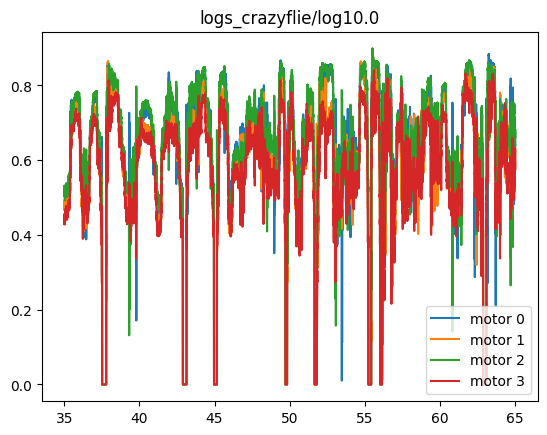

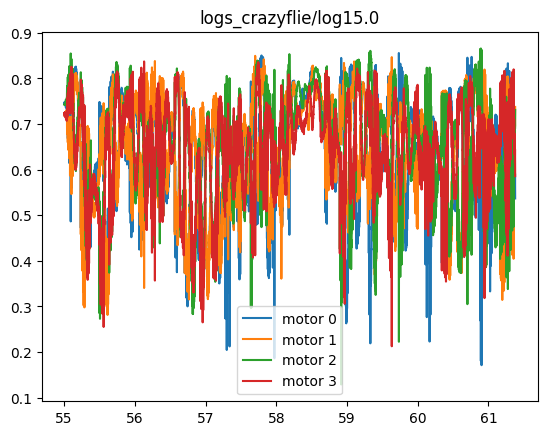

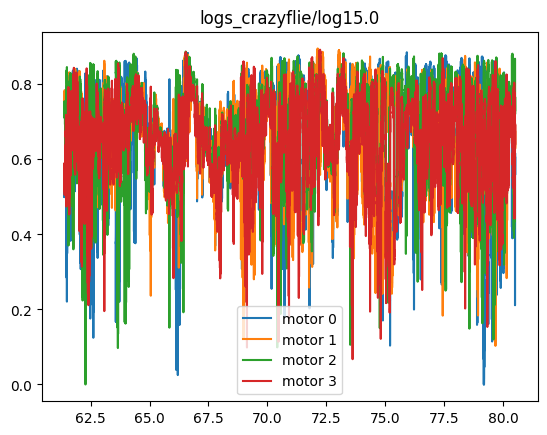

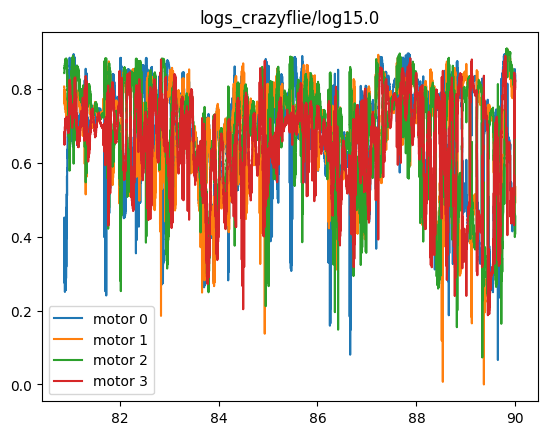

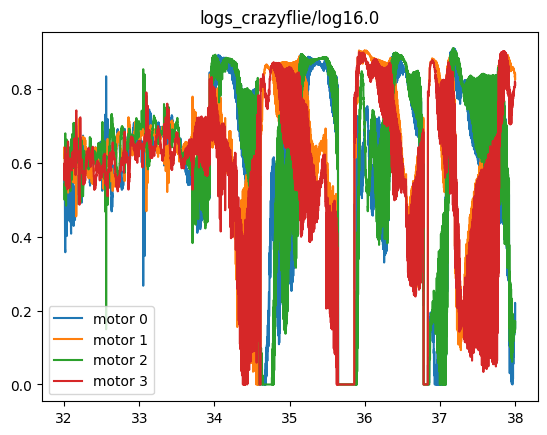

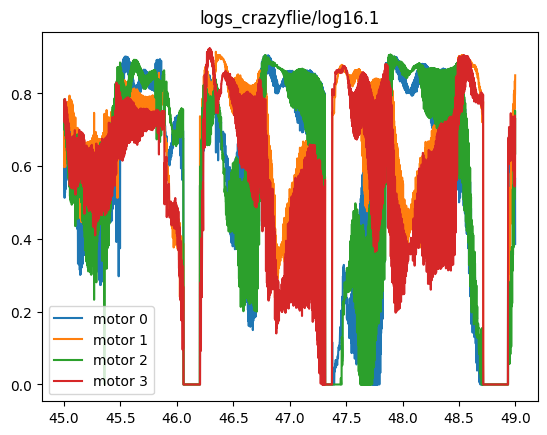

In [11]:
sliced_and_interpolated_flights_thrust = slice_gaps_and_interpolate(flights_thrust)
sliced_and_interpolated_flights_inertia_roll_pitch = slice_gaps_and_interpolate(flights_inertia_roll_pitch)
sliced_and_interpolated_flights_inertia_yaw = slice_gaps_and_interpolate(flights_inertia_yaw)

# Step 4: Apply stateful transformation (filter motor data)

In [12]:
def filter_ema(timestamps, rpm_setpoints, T_m):
    rpms_filtered = []
    rpm = None
    previous_t = None
    for t, rpm_setpoint in zip(timestamps, rpm_setpoints):
        if rpm is None:
            rpm = rpm_setpoint
        else:
            delta_t = t - previous_t
            alpha = np.exp(-delta_t / T_m)
            rpm = alpha*rpm + (1-alpha) * rpm_setpoint
        rpms_filtered.append(rpm)
        previous_t = t
    return np.array(rpms_filtered)

def combine(flights, T_m, T_omega=0.05, thrust_curves=None):
    assert thrust_curves is None or len(thrust_curves) == 4
    from scipy.spatial.transform import Rotation as R
    def FRD2FLU(x):
        return np.array([x[0], -x[1], -x[2]])

    def FRD2FLU_quat(q):
        return R.from_quat([q[1], -q[2], -q[3], q[0]])
    from copy import deepcopy
    new_flights = []
    for flight in flights:
        new_flight = {}
        timestamps = flight["timestamps"]
        frd = flight["convention"] == "frd"
        rpm_setpoints = np.array([flight["data"][f"{output_topic}_control[{i}]"]["values"] for i in range(4)]).T

        acceleration_original_frame = np.array([flight["data"][f"vehicle_acceleration_xyz[{i}]"]["values"] for i in range(3)]).T
        acceleration = np.array(list(map(FRD2FLU, acceleration_original_frame))) if frd else acceleration_original_frame
        omega_original_frame = np.array([flight["data"][f"vehicle_angular_velocity_xyz[{i}]"]["values"] for i in range(3)]).T
        omega = np.array(list(map(FRD2FLU, omega_original_frame))) if frd else omega_original_frame
        if f"vehicle_angular_velocity_xyz_derivative[0]" in flight["data"]:
            domega_original_frame = np.array([flight["data"][f"vehicle_angular_velocity_xyz_derivative[{i}]"]["values"] for i in range(3)]).T
            domega = np.array(list(map(FRD2FLU, domega_original_frame))) if frd else domega_original_frame
        else:
            domega = flight["domega_gradient"] = np.gradient(omega, timestamps, axis=0)
        flight["rpm_setpoints"] = rpm_setpoints
        flight["rpms"] = filter_ema(timestamps, rpm_setpoints, T_m)
        flight["acceleration"] = acceleration
        flight["omega"] = omega
        flight["domega"] = domega
        
        if thrust_curves is not None:
            def apply_thrust_curves(rpms, thrust_curves):
                thrusts = []
                for thrust_curve_motor, rpm in zip(thrust_curves, rpms):
                    acc = 0
                    for exponent, coeff in zip(range(3), thrust_curve_motor):
                        acc += rpm**exponent * coeff
                    thrusts.append(acc)
                return np.array(thrusts)
            flight["thrusts"] = np.array([apply_thrust_curves(rpms, thrust_curves) for rpms in flight["rpms"]])
            motor_thrust_to_torque_geometric = np.array([np.cross(model["rotor_positions"][motor_i], model["rotor_thrust_directions"][motor_i]) for motor_i in range(4)])
            flight["pre_torque"] = flight["thrusts"][:, :, np.newaxis] * model["rotor_torque_directions"]
            flight["pre_torque_geometric"] = flight["thrusts"][:, :, np.newaxis] * motor_thrust_to_torque_geometric
        
    
    thrusts_combined = {}
    if thrust_curves is not None:
        thrusts_combined = {
            "thrusts": np.concatenate([flight["thrusts"] for flight in flights]),
            "pre_torque": np.concatenate([flight["pre_torque"] for flight in flights]),
            "pre_torque_geometric": np.concatenate([flight["pre_torque_geometric"] for flight in flights]),
        }

    return {
        "rpm_setpoints": np.concatenate([flight["rpm_setpoints"] for flight in flights]),
        "rpms": np.concatenate([flight["rpms"] for flight in flights]),
        "acceleration": np.concatenate([flight["acceleration"] for flight in flights]),
        "omega": np.concatenate([flight["omega"] for flight in flights]),
        "domega": np.concatenate([flight["domega"] for flight in flights]),
        **thrusts_combined
    }, flights


In [13]:
T_m_test = 0.05
combined_test, _ = combine(sliced_and_interpolated_flights_thrust, T_m_test)

In [14]:
def estimate_motor_parameters(combined, model, exponents, verbose=True, separate=True):
    b = []
    A = []
    num_steps = len(combined["rpms"])
    for step_i in range(num_steps):
        acceleration = combined["acceleration"][step_i]
        b.append(model["mass"] * acceleration)
        current_A = []
        rpm = combined["rpms"][step_i]
        if separate:
            for motor_i in range(4):
                for exponent in exponents:
                    current_A.append(model["rotor_thrust_directions"][motor_i] * rpm[motor_i] ** exponent)
        else:
            for exponent in exponents:
                acc = np.zeros(3)
                for motor_i in range(4):
                    acc += model["rotor_thrust_directions"][motor_i] * rpm[motor_i] ** exponent
                current_A.append(acc)
        A.append(np.array(current_A).T)

    A = np.array(A).reshape(-1, (4 if separate else 1) * len(exponents))
    b = np.array(b).reshape(-1)
    if verbose:
        print(f"A shape: {A.shape}")
        print(f"b shape: {b.shape}")
    K_f = np.linalg.lstsq(A, b, rcond=None)[0].reshape(-1, len(exponents))
    rmse = np.sqrt(np.mean((A @ K_f.reshape(-1) - b) ** 2))
    if separate:
        K_f_full = np.array([[K_f[motor_i][exponents.index(i)] if i in exponents else 0 for i in range(3)] for motor_i in range(4)])
    else:
        K_f_full = np.array([[K_f[0][exponents.index(i)] if i in exponents else 0 for i in range(3)] for motor_i in range(4)])
    return K_f_full, rmse

In [15]:
K_f_test, rmse = estimate_motor_parameters(combined_test, model, exponents_thrust_curve[0])
print(f"K_f_test: {K_f_test}")
K_f_test_mean = K_f_test.mean(axis=0)
print(f"K_f_test_mean: {K_f_test_mean}")

A shape: (90876, 12)
b shape: (90876,)
K_f_test: [[ 0.02154952  0.76200416 -0.4241035 ]
 [ 0.02154952 -0.57908117  0.45871317]
 [ 0.02154952  0.51226203 -0.15922357]
 [ 0.02154952 -0.85325043  0.75016471]]
K_f_test_mean: [ 0.02154952 -0.03951635  0.1563877 ]


In [16]:
from tqdm import tqdm
from tqdm.notebook import tqdm

T_m_candidates = np.linspace(0.001, 0.5 if model_name == "crazyflie" else 0.2, 100 if not debug else 20)
results = [[(T_m, *estimate_motor_parameters(combine(sliced_and_interpolated_flights_thrust, T_m)[0], model, exponents, verbose=False, separate=False)) for T_m in tqdm(T_m_candidates)] for exponents in exponents_thrust_curve]
T_ms, K_fs, rmses = zip(*results[0])

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

K_f: [[ 0.02126557 -0.01117503  0.12012994]
 [ 0.02126557 -0.01117503  0.12012994]
 [ 0.02126557 -0.01117503  0.12012994]
 [ 0.02126557 -0.01117503  0.12012994]]
K_f_mean: [ 0.02126557 -0.01117503  0.12012994]


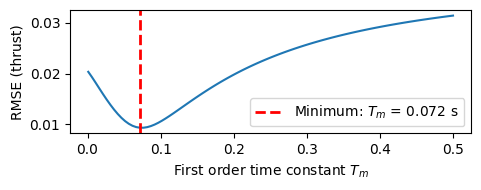

In [17]:
T_m = T_m_candidates[np.argmin(rmses)]
K_f = K_fs[np.argmin(rmses)]
K_f_mean = K_f.mean(axis=0)
print(f"K_f: {K_f}")
print(f"K_f_mean: {K_f_mean}")
plt.figure(figsize=(5, 2))
plt.plot(T_m_candidates, rmses)
plt.xlabel("First order time constant $T_m$")
plt.ylabel("RMSE (thrust)")
plt.axvline(x=T_m, color='red', linestyle='--', linewidth=2, label=f"Minimum: $T_m$ = {T_m:.3f} s")
plt.legend()
plt.tight_layout()
plt.savefig(f"figures/{model_name}_finding_tau.pdf")
plt.show()

thrust_curves = np.array([K_f_mean for _ in range(4)])

combined_thrust, flights_thrust_processed = combine(sliced_and_interpolated_flights_thrust, T_m, thrust_curves=thrust_curves)
combined_inertia_roll_pitch, flights_inertia_roll_pitch_processed = combine(sliced_and_interpolated_flights_inertia_roll_pitch, T_m, thrust_curves=thrust_curves)
combined_inertia_yaw, flights_inertia_yaw_processed = combine(sliced_and_interpolated_flights_inertia_yaw, T_m, thrust_curves=thrust_curves)

K_f_squared_mean: [0.         0.         0.15002497]


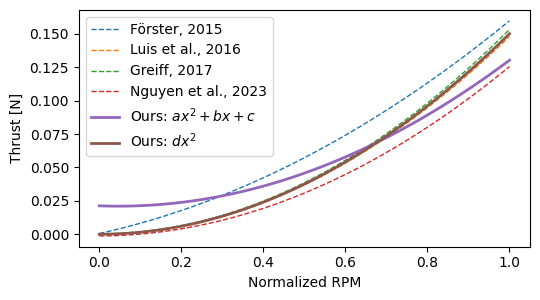

In [18]:
if model_name == "crazyflie":
    _, K_fs_squared, _ = zip(*results[1])
    K_f_squared = K_fs_squared[np.argmin(rmses)]
    K_f_squared_mean = K_f_squared.mean(axis=0)
    print(f"K_f_squared_mean: {K_f_squared_mean}")
    K_f_comparison = np.array([
        [5.48e-04, 6.77e-02, 9.15e-02],
        [0, 0, 1.48e-1],
        [3.75e-04, -1.23e-04, 1.53e-01],
        [-1.30e-03, 1.75e-03, 1.25e-01],
        K_f_mean,
        K_f_squared_mean
    ])
    labels = [
        "Förster, 2015",
        "Luis et al., 2016",
        "Greiff, 2017",
        "Nguyen et al., 2023",
        "Ours: $ax^2 + bx + c$",
        "Ours: $dx^2$",
    ]
    input_rpms = np.linspace(0, 1, 100)
    plt.figure(figsize=(5.5,3.1))
    for label, K_f in zip(labels, K_f_comparison):
        predictions = []
        for x in input_rpms:
            acc = 0
            for i in range(3):
                acc += K_f[i] * x ** i
            predictions.append(acc)
        ours = label.startswith("Ours")
        plt.plot(input_rpms, predictions, label=label, linestyle="-" if ours else "--", linewidth=2 if ours else 1)
    plt.legend()
    plt.xlabel("Normalized RPM")
    plt.ylabel("Thrust [N]")
    plt.tight_layout()
    plt.savefig(f"figures/{model_name}_thrust_curve_comparison.pdf")
    plt.show()
        

hover perc 0.2116013681888583
abs_acc: [3.13125543 3.05597076 3.06471236 ... 0.82879202 0.80165071 0.7457534 ]
masking rate0.9499867951934504


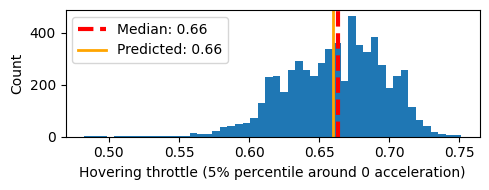

In [19]:
acceleration = combined_thrust["acceleration"][:, 2] - 9.81
abs_acceleration = np.abs(acceleration)
hovering_percentile = 2*2.5
acceleration_hover_perc = np.percentile(abs_acceleration, hovering_percentile)
print(f"hover perc {acceleration_hover_perc}")
print(f"abs_acc: {abs_acceleration}")
mask = abs_acceleration < acceleration_hover_perc
print(f"masking rate{1-mask.mean()}")
hovering_rpms = combined_thrust["rpms"][mask]
hovering_rpm = np.median(hovering_rpms.ravel())
plt.figure(figsize=(5, 2))
plt.hist(hovering_rpms.ravel(), bins=50)
plt.xlabel(f"Hovering throttle ({int(hovering_percentile)}% percentile around 0 acceleration)")
plt.ylabel("Count")
plt.axvline(x=hovering_rpm, color='red', linestyle='--', linewidth=3, label=f"Median: {hovering_rpm:.2f}")
predicted_hovering_rpm = (-K_f_mean[1] + np.sqrt(K_f_mean[1]**2 - 4*K_f_mean[2]*(K_f_mean[0] - 9.81*model["mass"]/4)))/(2*K_f_mean[2])
plt.axvline(x=predicted_hovering_rpm, color='orange', linestyle='-', linewidth=2, label=f"Predicted: {predicted_hovering_rpm:.2f}")
plt.legend()
plt.tight_layout()
plt.savefig(f"figures/{model_name}_hovering_throttle.pdf")
plt.show()

In [20]:
if model_name == "crazyflie" and create_motor_delay_animation:
    from matplotlib.animation import FuncAnimation

    animation_data = list(zip(T_ms, K_fs))
    T_m_index = list(T_m_candidates).index(T_m)
    animation_slow_first_part = np.repeat(np.array(animation_data[:(T_m_index+1)], dtype=object), 3, axis=0)
    animation_trace = [*animation_data, *animation_data[::-1], *animation_slow_first_part]
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))

    animation_x_lim = None
    animation_y_lim = None
    pbar = tqdm(total=len(animation_trace)-1)
    def update(frame):
        pbar.n = frame
        pbar.refresh()
        global animation_x_lim, animation_y_lim
        animation_T_m, animation_K_f = animation_trace[frame]
        animation_K_f_mean = animation_K_f.mean(axis=0)
        animation_thrust_curves = np.array([animation_K_f_mean for _ in range(4)])
        animation_combined_thrust, flights_thrust_processed = combine(sliced_and_interpolated_flights_thrust, animation_T_m, thrust_curves=animation_thrust_curves)

        animation_squared_rpm_setpoint = (animation_combined_thrust["rpm_setpoints"]**2).sum(axis=1)
        animation_squared_rpm = (animation_combined_thrust["rpms"]**2).sum(axis=1)
        animation_actual_thrust = animation_combined_thrust["acceleration"][:, 2]*model["mass"]
        axs[0].cla()
        axs[1].cla()
        ax = 0
        axs[ax].plot(T_m_candidates, rmses)
        axs[ax].set_xlabel("First order time constant $T_m$")
        axs[ax].set_ylabel("RMSE (thrust)")
        axs[ax].axvline(x=animation_T_m, color='red', linestyle='--', linewidth=2, label=f"$T_m$ = {animation_T_m:.3f} s")
        axs[ax].legend()
        ax += 1
        axs[ax].scatter(animation_squared_rpm, animation_actual_thrust, s=0.01)
        axs[ax].set_xlabel("$\omega_{{m}_1}^2 + \omega_{{m}_2}^2 + \omega_{{m}_3}^2 + \omega_{{m}_4}^2$")
        axs[ax].set_ylabel("Actual thrust [N]")
        if animation_x_lim is None:
            animation_x_lim = axs[ax].get_xlim()
            animation_y_lim = axs[ax].get_ylim()
        else:
            axs[ax].set_xlim(animation_x_lim)
            axs[ax].set_ylim(animation_y_lim)
        fig.tight_layout()

    anim = FuncAnimation(fig, update, frames=len(animation_trace), interval=50)
    anim.save(f'{model_name}_motor_constant_animation.mp4', writer='ffmpeg', dpi=1000)
    plt.show()

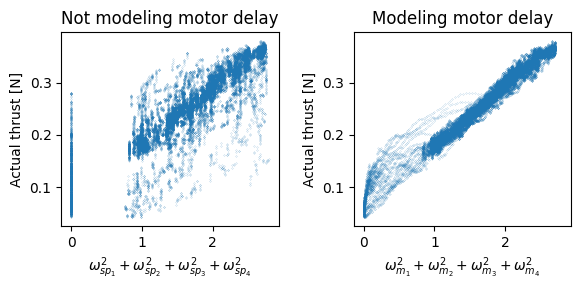

In [21]:
T_m, K_fs

squared_rpm_setpoint = (combined_thrust["rpm_setpoints"]**2).sum(axis=1)
squared_rpm = (combined_thrust["rpms"]**2).sum(axis=1)
actual_thrust = combined_thrust["acceleration"][:, 2]*model["mass"]
fig, axs = plt.subplots(1, 2, figsize=(6, 3), sharex=True)
ax = 0
axs[ax].scatter(squared_rpm_setpoint, actual_thrust, s=0.01)
axs[ax].set_title("Not modeling motor delay")
axs[ax].set_xlabel("$\omega_{{sp}_1}^2 + \omega_{{sp}_2}^2 + \omega_{{sp}_3}^2 + \omega_{{sp}_4}^2$")
axs[ax].set_ylabel("Actual thrust [N]")
ax += 1
axs[ax].scatter(squared_rpm, actual_thrust, s=0.01)
axs[ax].set_title("Modeling motor delay")
axs[ax].set_xlabel("$\omega_{{m}_1}^2 + \omega_{{m}_2}^2 + \omega_{{m}_3}^2 + \omega_{{m}_4}^2$")
axs[ax].set_ylabel("Actual thrust [N]")
fig.tight_layout()
fig.savefig(f"figures/{model_name}_thrust_curve_delay_comparison.pdf")
fig.savefig(f"figures/{model_name}_thrust_curve_delay_comparison.jpg", dpi=dpi)

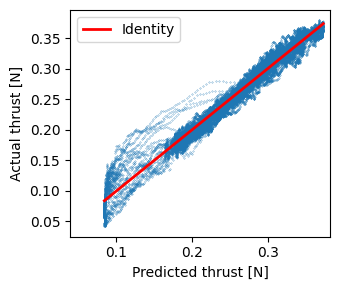

In [22]:
predicted_thrust = combined_thrust["thrusts"].sum(axis=1)
actual_thrust = combined_thrust["acceleration"][:, 2]*model["mass"]
plt.figure(figsize=(3.5,3))
plt.scatter(predicted_thrust, actual_thrust, s=0.05)
plt.plot([predicted_thrust.min(), predicted_thrust.max()], [predicted_thrust.min(), predicted_thrust.max()], linewidth=2, color="red", label="Identity")
plt.xlabel("Predicted thrust [N]")
plt.ylabel("Actual thrust [N]")
plt.legend()
thrust_min = min(predicted_thrust.min(), actual_thrust.min())
thrust_max = max(predicted_thrust.max(), actual_thrust.max())
thrust_range = thrust_max - thrust_min
relative_bound_x = 0.01
relative_bound_y = 0.05
# plt.axis("equal")
plt.xlim([thrust_min - relative_bound_x * thrust_range, thrust_max + relative_bound_x * thrust_range])
plt.ylim([thrust_min - relative_bound_y * thrust_range, thrust_max + relative_bound_y * thrust_range])
plt.tight_layout()
plt.savefig(f"figures/{model_name}_thrust_curve_fit.pdf")
plt.savefig(f"figures/{model_name}_thrust_curve_fit.jpg", dpi=dpi)
plt.show()

domega lower: -0.008 upper: -0.008
masking rate: 0.000
I_xx: 1.0286343346554766e-05
domega lower: -0.114 upper: -0.114
masking rate: 0.000
I_yy: 1.1052384506476651e-05


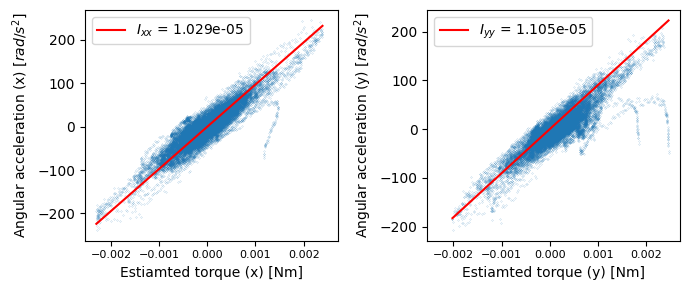

In [23]:
I = []
fig, axs = plt.subplots(1, 2, figsize=(7, 3), sharex=True)
for axis_i, axis_name in zip([0, 1], ["x", "y"]):
    ax = axs[axis_i]
    dw_full = combined_inertia_roll_pitch["domega"][:, axis_i]
    torque_full = combined_inertia_roll_pitch["pre_torque_geometric"].sum(axis=1)[:, axis_i]
    perc = 50
    dw_perc_lower = np.percentile(dw_full, perc)
    dw_perc_upper = np.percentile(dw_full, 100-perc)
    print(f"domega lower: {dw_perc_lower:.3f} upper: {dw_perc_upper:.3f}")
    mask = (dw_full < dw_perc_lower) | (dw_full > dw_perc_upper)
    torques_perc_lower = np.percentile(torque_full, perc)
    torques_perc_upper = np.percentile(torque_full, 100-perc)
    # mask &= (torque_full < torques_perc_lower) | (torque_full > torques_perc_upper)
    print(f"masking rate: {1-mask.mean():.3f}")
    dw = dw_full[mask]
    torque = torque_full[mask]

    I_axis = 1/(dw**2).sum() * np.inner(dw, torque)
    print(f"I_{axis_name}{axis_name}: {I_axis}")
    if perc < 50:
        ax.scatter(torque_full, dw_full, s=0.10)
    ax.scatter(torque, dw, s=0.01)
    torques_in = np.linspace(torque_full.min(), torque_full.max(), 100)
    ax.plot(torques_in, torques_in / (I_axis), color="red", label=f"$I_{{{axis_name}{axis_name}}}$ = {I_axis:.3e}")
    ax.set_xlabel(f"Estiamted torque ({axis_name}) [Nm]")
    ax.set_ylabel(f"Angular acceleration ({axis_name}) [$rad/s^{{2}}$]")
    ax.tick_params(axis='x', which='major', labelsize=8)
    ax.legend()
    I.append(I_axis)
fig.tight_layout()
fig.savefig(f"figures/{model_name}_inertia.pdf")
fig.savefig(f"figures/{model_name}_inertia.jpg", dpi=dpi)

In [24]:
I_xx, I_yy = I[:2]
I_zz = (I_xx + I_yy)/2 * inertia_ratio
I = [I_xx, I_yy, I_zz]
print(f"I_xx: {I_xx}, I_yy: {I_yy}, I_zz: {I_zz},")

I_xx: 1.0286343346554766e-05, I_yy: 1.1052384506476651e-05, I_zz: 1.954627471337678e-05,


b: 0.0017920473827368168


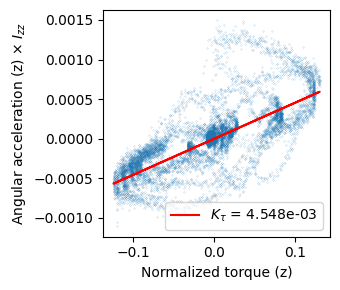

In [25]:
K_taus = []
combined_inertia_yaw["thrusts"].shape
model["rotor_torque_directions"].shape
thrust_torques_inputs = combined_inertia_yaw["thrusts"][:, :, np.newaxis] * model["rotor_torque_directions"]
thrust_torque_inputs_z_full = thrust_torques_inputs[:, :, 2].sum(axis=1)
dwz_full = combined_inertia_yaw["domega"][:, 2]

thrust_torque_inputs_z = thrust_torque_inputs_z_full
dwz = dwz_full

b_full = dwz_full * I_zz
b = dwz * I_zz

K_tau = 1/(thrust_torque_inputs_z ** 2).sum() * np.inner(thrust_torque_inputs_z, b)
print(f"b: {(b**2).sum()}")
K_taus.append(K_tau)

plt.figure(figsize=(3.5,3))
plt.scatter(thrust_torque_inputs_z_full, b_full, s=0.01)
plt.plot(thrust_torque_inputs_z, K_tau * thrust_torque_inputs_z, color="red", label=r"$K_\tau$"+f" = {K_tau:.3e}")
plt.ylabel(f"Angular acceleration (z) $\\times$ $I_{{zz}}$ ")
plt.xlabel(f"Normalized torque (z)")
plt.legend()
plt.tight_layout()
plt.savefig(f"figures/{model_name}_K_tau.pdf")
plt.savefig(f"figures/{model_name}_K_tau.jpg", dpi=dpi)
plt.show()